In [457]:
#Importing Libraries
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,roc_auc_score,plot_confusion_matrix, classification_report, confusion_matrix, precision_score, recall_score, mean_squared_error, f1_score
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [458]:
data = pd.read_csv('fake_job_postings.csv')

In [459]:
data.shape

(17880, 18)

In [460]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [461]:
data.interpolate(inplace=True)
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [462]:
data["has_company_logo"].value_counts()

1    14220
0     3660
Name: has_company_logo, dtype: int64

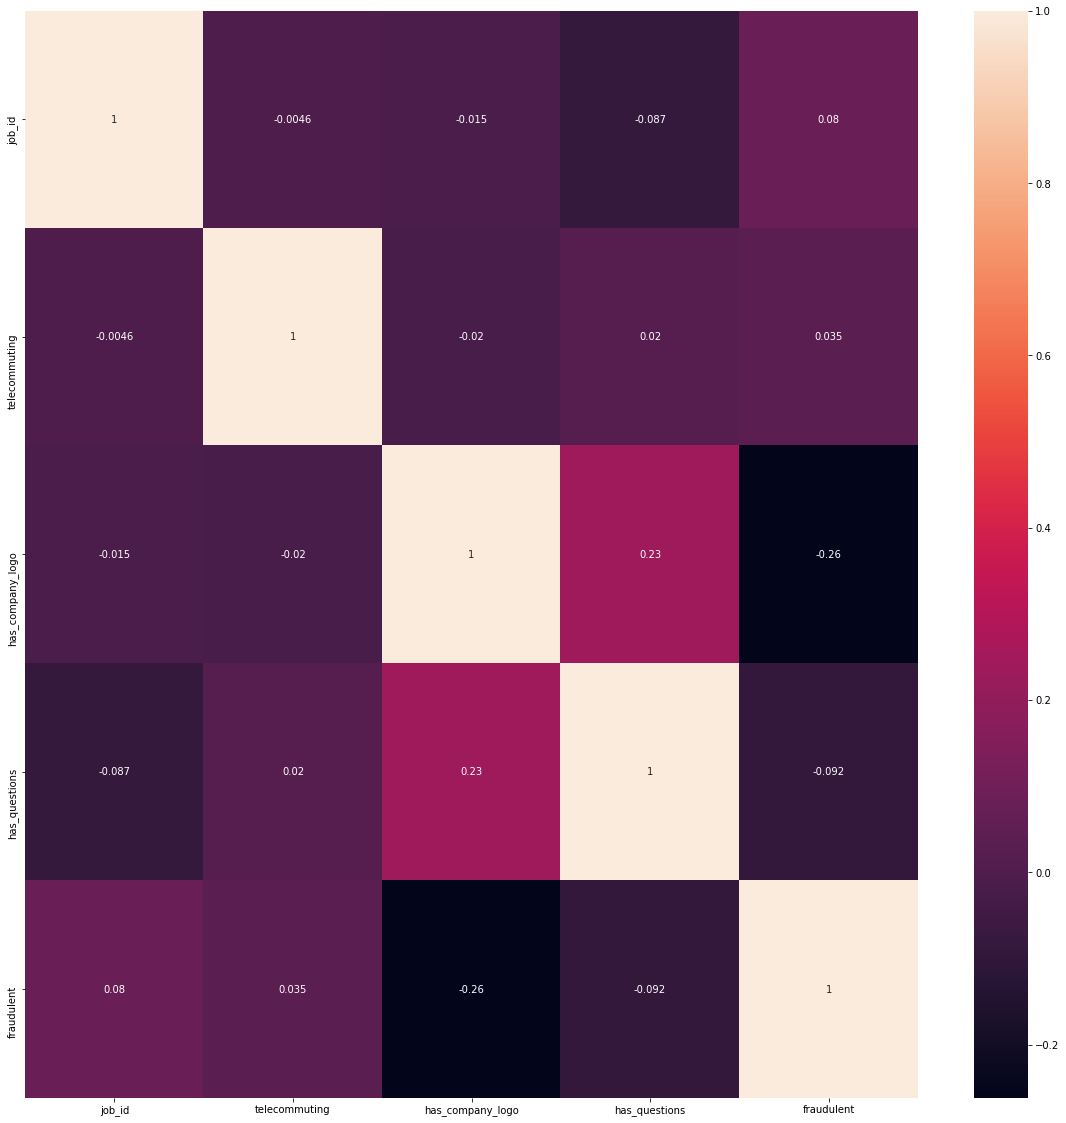

In [463]:
import seaborn as sns

import matplotlib.pyplot as plt

# taking all rows but only 6 columns
corr=data.corr()
top_features=corr.index
plt.figure(figsize=(20,20))

sns.heatmap(data[top_features].corr(), annot=True)


In [464]:
#Delete the unnecessary columns
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range']
for col in columns:
    del data[col]

#Fill NaN values with blank space
data.fillna(' ', inplace=True)

data.head()

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [465]:
df["employment_type"].value_counts()

Full-time    11620
0             3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

,fraudulent
0,17014
1,866


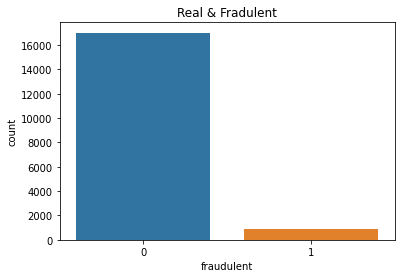

In [466]:
sns.countplot(data.fraudulent).set_title('Real & Fradulent')
pd.DataFrame(data["fraudulent"].value_counts())

Text(0.5, 0, 'Countries')

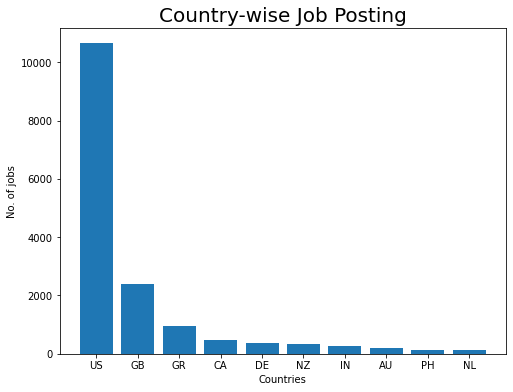

In [467]:
#Visualize job postings by countries
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)
country = dict(data.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

In [468]:
data.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'country'],
      dtype='object')

{'Mid-Senior level': 3809, 'Entry level': 2697, 'Associate': 2297, 'Not Applicable': 1116, 'Director': 389, 'Internship': 381, 'Executive': 141}


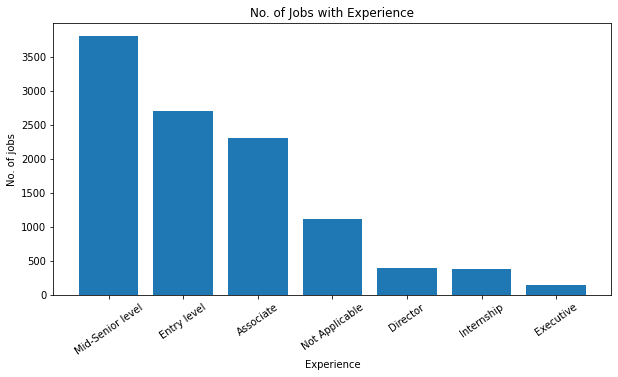

In [469]:
#Visualize the required experiences in the jobs
experience = dict(data.required_experience.value_counts())
del experience[' ']
print(experience)

plt.figure(figsize=(10,5))
plt.bar(experience.keys(), experience.values())
plt.title('No. of Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

In [470]:
#Most frequent jobs
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [471]:
#Titles and count of fraudulent jobs
print(data[data.fraudulent==1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Payroll Clerk                                                           10
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Name: title, dtype: int64


In [472]:
#Titles and count of real jobs
print(data[data.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [473]:
data.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'country'],
      dtype='object')

In [474]:
#combine text in a single column to start cleaning our data
data['text']=data['title']+' '+data['location']+' '+data['department']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']+' '+data['employment_type']+' '+data['required_experience']+' '+data['required_education']+' '+data['industry']+' '+data['function']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']
del data['employment_type']

In [475]:
data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotS..."


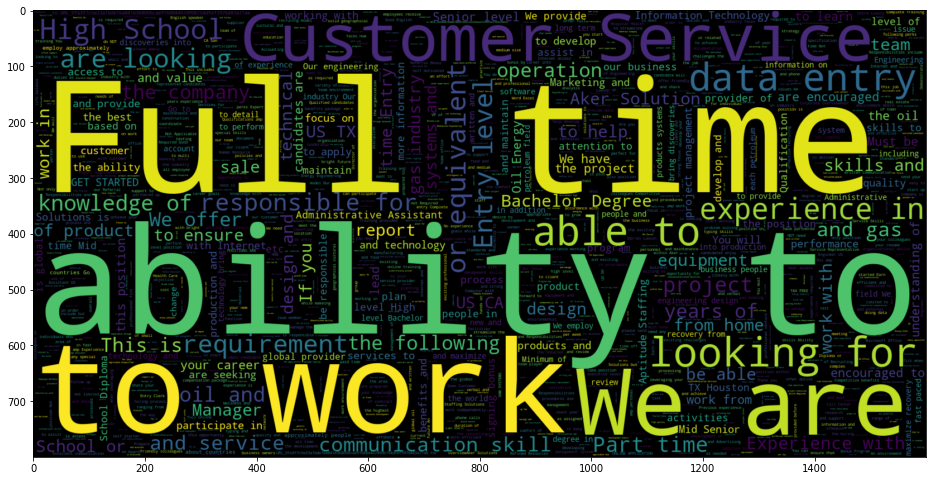

In [476]:
#Separate fraud and actual jobs
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

#Fraudulent jobs word cloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

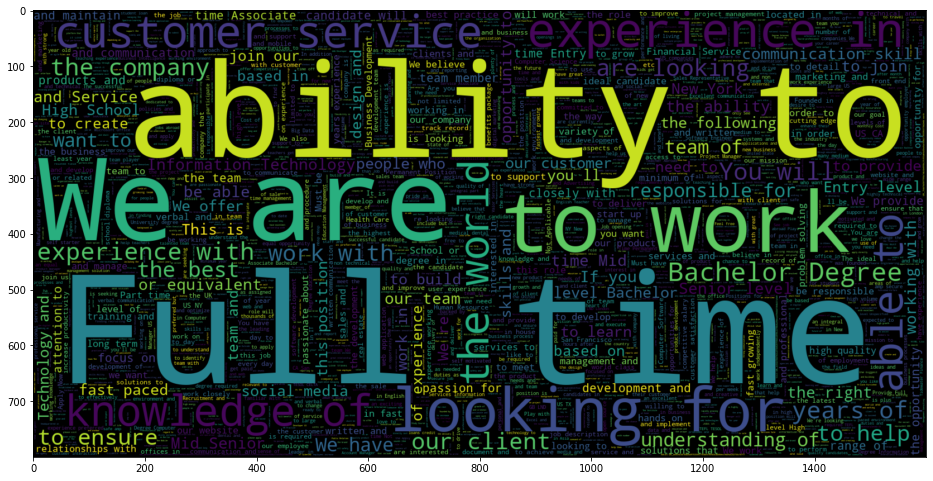

In [477]:
#Actual jobs wordcloud
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [478]:
data["text"][0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [479]:
data["text"] = data["text"].str.replace(r'\W', ' ').str.replace(r'\s$','')

In [480]:
data["text"][0]

'Marketing Intern US  NY  New York Marketing We re Food52  and we ve created a groundbreaking and award winning cooking site  We support  connect  and celebrate home cooks  and give them everything they need in one place We have a top editorial  business  and engineering team  We re focused on using technology to find new and better ways to connect people around their specific food interests  and to offer them superb  highly curated information about food and cooking  We attract the most talented home cooks and contributors in the country  we also publish well known professionals like Mario Batali  Gwyneth Paltrow  and Danny Meyer  And we have partnerships with Whole Foods Market and Random House Food52 has been named the best food website by the James Beard Foundation and IACP  and has been featured in the New York Times  NPR  Pando Daily  TechCrunch  and on the Today Show We re located in Chelsea  in New York City  Food52  a fast growing  James Beard Award winning online food communi

In [481]:
# Splitting dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

#Train-test shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12516,)
(12516,)
(5364,)
(5364,)


In [482]:
X_test

5947     DP   Director of Photography US  NY  NY     Re...
3602     Sales   Business Development Manager GB  GBN  ...
14921    Data Scientist GB  LND  Farringdon Engineering...
13139    Automotive Controls Engineer US  OH  Cleveland...
10715    Senior iOS Developer   SportsLock US  IL  Chic...
                               ...                        
930      Office Assistant US  TX  Austin Operations Why...
9991     Linux System Administrator CA  ON  Toronto    ...
3594     Client Services Co ordinator GB  LND  Leyton C...
16910    Promotions   Marketing Assistant US  TX  Carro...
11934    Design Engineer US  OH  Cleveland   We Provide...
Name: text, Length: 5364, dtype: object

In [483]:
from sklearn import tree

In [484]:
Accuracy={}
Mean_Squared_Error={}
Roc_auc_score={}

In [485]:
#Decision_tree
Decision_tree_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', tree.DecisionTreeClassifier())])

model_decision_tree = Decision_tree_pipe.fit(X_train, y_train)
decision_tree_pred = model_decision_tree.predict(X_test)


Accuracy["Decision_tree"]=accuracy_score(y_test, decision_tree_pred)*100
Mean_Squared_Error["Decision_tree"]=mean_squared_error(y_test, decision_tree_pred)
Roc_auc_score["Decision_tree"]=roc_auc_score(y_test, decision_tree_pred)

print("Accuracy of Decision Tree Classifier: {}%".format(round(accuracy_score(y_test, decision_tree_pred)*100,2)))
print("\nMean Squared Error of Decision Tree Classifier: {}%".format(mean_squared_error(y_test, decision_tree_pred)))
print ("Roc_auc_score of Decision Tree Classifier: {}%".format(roc_auc_score(y_test, decision_tree_pred)))

print("\nConfusion Matrix of Decision Tree Classifier:\n")
print(confusion_matrix(y_test, decision_tree_pred))
print("\nClassification Report of Decision Tree Classifier:\n")
print(classification_report(y_test, decision_tree_pred))

Accuracy of Decision Tree Classifier: 97.63%

Mean Squared Error of Decision Tree Classifier: 0.023676360924683074%
Roc_auc_score of Decision Tree Classifier: 0.8578031068079673%

Confusion Matrix of Decision Tree Classifier:

[[5036   51]
 [  76  201]]

Classification Report of Decision Tree Classifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5087
           1       0.80      0.73      0.76       277

    accuracy                           0.98      5364
   macro avg       0.89      0.86      0.87      5364
weighted avg       0.98      0.98      0.98      5364



In [486]:
#Support Vector classification
Support_Vector_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LinearSVC())])

model_svc = Support_Vector_pipe.fit(X_train, y_train)
svc_pred = model_svc.predict(X_test)

Accuracy["Support_Vector"]=accuracy_score(y_test, svc_pred)*100
Mean_Squared_Error["Support_Vector"]=mean_squared_error(y_test, svc_pred)
Roc_auc_score["Support_Vector"]=roc_auc_score(y_test, svc_pred)

print("Accuracy of SVM Classifier: {}%".format(round(accuracy_score(y_test, svc_pred)*100,2)))
print("\nMean Squared Error of SVM Classifier: {}%".format(mean_squared_error(y_test, svc_pred)))
print ("Roc_auc_score of SVM Classifier: {}%".format(roc_auc_score(y_test, svc_pred)))

print("\nConfusion Matrix of SVM Classifier:\n")
print(confusion_matrix(y_test, svc_pred))
print("\nClassification Report of SVM Classifier:\n")
print(classification_report(y_test, svc_pred))

Accuracy of SVM Classifier: 98.53%

Mean Squared Error of SVM Classifier: 0.014727815063385533%
Roc_auc_score of SVM Classifier: 0.8625210152019128%

Confusion Matrix of SVM Classifier:

[[5084    3]
 [  76  201]]

Classification Report of SVM Classifier:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5087
           1       0.99      0.73      0.84       277

    accuracy                           0.99      5364
   macro avg       0.99      0.86      0.91      5364
weighted avg       0.99      0.99      0.98      5364



In [487]:
#Logistic regression classification
logistic_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])

model_logistic = logistic_pipe.fit(X_train, y_train)
logistic_pred = model_logistic.predict(X_test)

Accuracy["Logistic"]=accuracy_score(y_test, logistic_pred)*100
Mean_Squared_Error["Logistic"]=mean_squared_error(y_test, logistic_pred)
Roc_auc_score["Logistic"]=roc_auc_score(y_test, logistic_pred)

print("Accuracy of Logistic Classifier: {}%".format(round(accuracy_score(y_test, logistic_pred)*100,2)))
print("\nMean Squared Error of Logistic Classifier: {}%".format(mean_squared_error(y_test, logistic_pred)))
print ("Roc_auc_score of Logistic Classifier: {}%".format(roc_auc_score(y_test, logistic_pred)))

print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test, logistic_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test, logistic_pred))


Accuracy of Logistic Classifier: 96.87%

Mean Squared Error of Logistic Classifier: 0.03131991051454139%
Roc_auc_score of Logistic Classifier: 0.698457666920493%

Confusion Matrix of Logistic Regression Classifier:

[[5086    1]
 [ 167  110]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5087
           1       0.99      0.40      0.57       277

    accuracy                           0.97      5364
   macro avg       0.98      0.70      0.78      5364
weighted avg       0.97      0.97      0.96      5364



In [488]:
#AdaBoost Classifier
AdaBoost_Classifier_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', AdaBoostClassifier())])

model_AdaBoost_Classifier = AdaBoost_Classifier_pipe.fit(X_train, y_train)
AdaBoost_Classifier_pred = model_AdaBoost_Classifier.predict(X_test)

Accuracy["AdaBoost"]=accuracy_score(y_test, AdaBoost_Classifier_pred)*100
Mean_Squared_Error["AdaBoost"]=mean_squared_error(y_test, AdaBoost_Classifier_pred)
Roc_auc_score["AdaBoost"]=roc_auc_score(y_test, AdaBoost_Classifier_pred)

print("Accuracy of AdaBoost Classifier: {}%".format(round(accuracy_score(y_test, AdaBoost_Classifier_pred)*100,2)))
print("\nMean Squared Error of AdaBoost Classifier: {}%".format(mean_squared_error(y_test, AdaBoost_Classifier_pred)))
print ("Roc_auc_score of AdaBoost Classifier: {}%".format(roc_auc_score(y_test, AdaBoost_Classifier_pred)))

print("\nConfusion Matrix of Adaboost Classifier:\n")
print(confusion_matrix(y_test, AdaBoost_Classifier_pred))
print("\nCLassification Report of Adaboost Classifier:\n")
print(classification_report(y_test, AdaBoost_Classifier_pred))

Accuracy of AdaBoost Classifier: 96.98%

Mean Squared Error of AdaBoost Classifier: 0.030201342281879196%
Roc_auc_score of AdaBoost Classifier: 0.7775585675669346%

Confusion Matrix of Adaboost Classifier:

[[5046   41]
 [ 121  156]]

CLassification Report of Adaboost Classifier:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5087
           1       0.79      0.56      0.66       277

    accuracy                           0.97      5364
   macro avg       0.88      0.78      0.82      5364
weighted avg       0.97      0.97      0.97      5364



In [489]:
#Random Forest classification
Random_Forest_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', RandomForestClassifier())])

model_Random_Forest = Random_Forest_pipe.fit(X_train, y_train)
Random_Forest_pred = model_Random_Forest.predict(X_test)

Accuracy["Random_Forest"]=accuracy_score(y_test, Random_Forest_pred)*100
Mean_Squared_Error["Random_Forest"]=mean_squared_error(y_test, Random_Forest_pred)
Roc_auc_score["Random_Forest"]=roc_auc_score(y_test, Random_Forest_pred)

print("Accuracy of Random Forest Classifier: {}%".format(round(accuracy_score(y_test, Random_Forest_pred)*100,2)))
print("\nMean Squared Error of Random Forest Classifier: {}%".format(mean_squared_error(y_test, Random_Forest_pred)))
print ("Roc_auc_score of Random Forest Classifier: {}%".format(roc_auc_score(y_test, Random_Forest_pred)))

print("\nConfusion Matrix of Random Forest Classifier:\n")
print(confusion_matrix(y_test, Random_Forest_pred))
print("\nCLassification Report of Random Forest Classifier:\n")
print(classification_report(y_test, Random_Forest_pred))

Accuracy of Random Forest Classifier: 98.01%

Mean Squared Error of Random Forest Classifier: 0.019947800149142433%
Roc_auc_score of Random Forest Classifier: 0.8068592057761732%

Confusion Matrix of Random Forest Classifier:

[[5087    0]
 [ 107  170]]

CLassification Report of Random Forest Classifier:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5087
           1       1.00      0.61      0.76       277

    accuracy                           0.98      5364
   macro avg       0.99      0.81      0.88      5364
weighted avg       0.98      0.98      0.98      5364



In [490]:
#K Nearest Neighbors classification
K_Nearest_Neighbors_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', KNeighborsClassifier(n_neighbors=3))])

model_K_Nearest_Neighbors = K_Nearest_Neighbors_pipe.fit(X_train, y_train)
K_Nearest_Neighbors_pred = model_K_Nearest_Neighbors.predict(X_test)

Accuracy["K_Nearest_Neighbors"]=accuracy_score(y_test, K_Nearest_Neighbors_pred)*100
Mean_Squared_Error["K_Nearest_Neighbors"]=mean_squared_error(y_test, K_Nearest_Neighbors_pred)
Roc_auc_score["K_Nearest_Neighbors"]=roc_auc_score(y_test, K_Nearest_Neighbors_pred)


print("Accuracy of K_Nearest_Neighbors Classifier: {}%".format(round(accuracy_score(y_test, K_Nearest_Neighbors_pred)*100,2)))
print("\nMean Squared Error of K Nearest Neighbors Classifier: {}%".format(mean_squared_error(y_test, K_Nearest_Neighbors_pred)))
print ("Roc_auc_score of K Nearest Neighbors Classifier: {}%".format(roc_auc_score(y_test, K_Nearest_Neighbors_pred)))

print("\nConfusion Matrix of K_Nearest_Neighbors Classifier:\n")
print(confusion_matrix(y_test, K_Nearest_Neighbors_pred))
print("\nCLassification Report of K_Nearest_Neighbors Classifier:\n")
print(classification_report(y_test, K_Nearest_Neighbors_pred))

Accuracy of K_Nearest_Neighbors Classifier: 98.14%

Mean Squared Error of K Nearest Neighbors Classifier: 0.018642803877703208%
Roc_auc_score of K Nearest Neighbors Classifier: 0.8689907522466483%

Confusion Matrix of K_Nearest_Neighbors Classifier:

[[5058   29]
 [  71  206]]

CLassification Report of K_Nearest_Neighbors Classifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5087
           1       0.88      0.74      0.80       277

    accuracy                           0.98      5364
   macro avg       0.93      0.87      0.90      5364
weighted avg       0.98      0.98      0.98      5364



In [491]:
vectorizer = CountVectorizer()
sentence_vectors = vectorizer.fit_transform(data["text"])

In [492]:
# Splitting dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors, data.fraudulent, test_size=0.3)

In [493]:
mlp = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

Accuracy["MLPAdam"]=accuracy_score(y_test, mlp_pred)*100
Mean_Squared_Error["MLPAdam"]=mean_squared_error(y_test, mlp_pred)
Roc_auc_score["MLPAdam"]=roc_auc_score(y_test, mlp_pred)

print("Accuracy of MLPAdam Classifier: {}%".format(round(accuracy_score(y_test, mlp_pred)*100,2)))
print("\nMean Squared Error:", mean_squared_error(y_test, mlp_pred))
print ("Roc_auc_score of MLPAdam Classifier: {}%".format(roc_auc_score(y_test, mlp_pred)))

print("\nConfusion Matrix of MLPAdam Classifier:\n")
print(confusion_matrix(y_test, mlp_pred))
print("\nCLassification Report of MLPAdam Classifier:\n")
print(classification_report(y_test, mlp_pred))

Accuracy of MLPAdam Classifier: 98.64%

Mean Squared Error: 0.013609246830723341
Roc_auc_score of MLPAdam Classifier: 0.9115576469010644%

Confusion Matrix of MLPAdam Classifier:

[[5078   29]
 [  44  213]]

CLassification Report of MLPAdam Classifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5107
           1       0.88      0.83      0.85       257

    accuracy                           0.99      5364
   macro avg       0.94      0.91      0.92      5364
weighted avg       0.99      0.99      0.99      5364



In [494]:
mlps = MLPClassifier(solver = 'sgd', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)
mlps.fit(X_train, y_train)
mlps_pred = mlps.predict(X_test)

Accuracy["MLPsgd"]=accuracy_score(y_test, mlps_pred)*100
Mean_Squared_Error["MLPsgd"]=mean_squared_error(y_test, mlps_pred)
Roc_auc_score["MLPsgd"]=roc_auc_score(y_test, mlps_pred)

print("Accuracy of MLPSgd Classifier: {}%".format(round(accuracy_score(y_test, mlps_pred)*100,2)))
print("\nMean Squared Error:", mean_squared_error(y_test, mlps_pred))
print ("Roc_auc_score of MLPsgd Classifier: {}%".format(roc_auc_score(y_test, mlps_pred)))

print("\nConfusion Matrix of MLPSgd Classifier:\n")
print(confusion_matrix(y_test, mlps_pred))
print("\nCLassification Report of MLPSgd Classifier:\n")
print(classification_report(y_test, mlps_pred))

Accuracy of MLPSgd Classifier: 98.47%

Mean Squared Error: 0.015287099179716629
Roc_auc_score of MLPsgd Classifier: 0.8718764738106467%

Confusion Matrix of MLPSgd Classifier:

[[5090   17]
 [  65  192]]

CLassification Report of MLPSgd Classifier:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5107
           1       0.92      0.75      0.82       257

    accuracy                           0.98      5364
   macro avg       0.95      0.87      0.91      5364
weighted avg       0.98      0.98      0.98      5364



In [495]:
from sklearn.naive_bayes import GaussianNB

In [496]:
# Splitting dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors.toarray(), data.fraudulent, test_size=0.3)

In [497]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

Accuracy["NaiveBayes"]=accuracy_score(y_test, y_pred)*100
Mean_Squared_Error["NaiveBayes"]=mean_squared_error(y_test, y_pred)
Roc_auc_score["NaiveBayes"]=roc_auc_score(y_test, y_pred)

print("Accuracy of Naive_bayes Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("\nMean Squared Error:", mean_squared_error(y_test, y_pred))
print ("Roc_auc_score of NaiveBayes Classifier: {}%".format(roc_auc_score(y_test, y_pred)))

print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report of Naive Bayes Classifier:\n")
print(classification_report(y_test, y_pred))

Accuracy of Naive_bayes Classifier: 98.28%

Mean Squared Error: 0.01715137956748695
Roc_auc_score of NaiveBayes Classifier: 0.8205152392721373%

Confusion Matrix of Naive Bayes Classifier:

[[5126   11]
 [  81  146]]

Classification Report of Naive Bayes Classifier:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5137
           1       0.93      0.64      0.76       227

    accuracy                           0.98      5364
   macro avg       0.96      0.82      0.88      5364
weighted avg       0.98      0.98      0.98      5364



In [498]:
data.head()

,fraudulent,text
0,0,Marketing Intern US NY New York Marketing We...
1,0,Customer Service Cloud Video Production NZ ...
2,0,Commissioning Machinery Assistant CMA US IA...
3,0,Account Executive Washington DC US DC Wash...
4,0,Bill Review Manager US FL Fort Worth SpotS...


In [499]:
features = data["text"]
targets = data["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [500]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [501]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [502]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [503]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [504]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
________________________________________________

In [505]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/15
430/430 [==============================] - 114s 266ms/step - loss: 0.2970 - accuracy: 0.9512 - val_loss: 0.1910 - val_accuracy: 0.9525
Epoch 2/15
430/430 [==============================] - 107s 250ms/step - loss: 0.2077 - accuracy: 0.9512 - val_loss: 0.1910 - val_accuracy: 0.9525
Epoch 3/15
430/430 [==============================] - 107s 250ms/step - loss: 0.1954 - accuracy: 0.9512 - val_loss: 0.1641 - val_accuracy: 0.9525
Epoch 4/15
430/430 [==============================] - 115s 267ms/step - loss: 0.1214 - accuracy: 0.9577 - val_loss: 0.1221 - val_accuracy: 0.9658
Epoch 5/15
430/430 [==============================] - 107s 250ms/step - loss: 0.0719 - accuracy: 0.9774 - val_loss: 0.1225 - val_accuracy: 0.9720
Epoch 6/15
430/430 [==============================] - 110s 256ms/step - loss: 0.0510 - accuracy: 0.9868 - val_loss: 0.1120 - val_accuracy: 0.9755
Epoch 7/15
430/430 [==============================] - 120s 278ms/step - loss: 0.0375 - accuracy: 0.9915 - val_loss: 0.1152 -

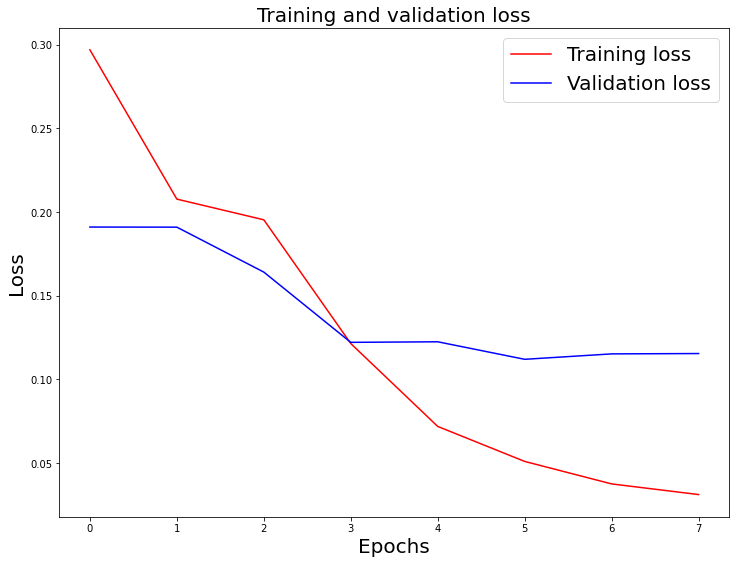

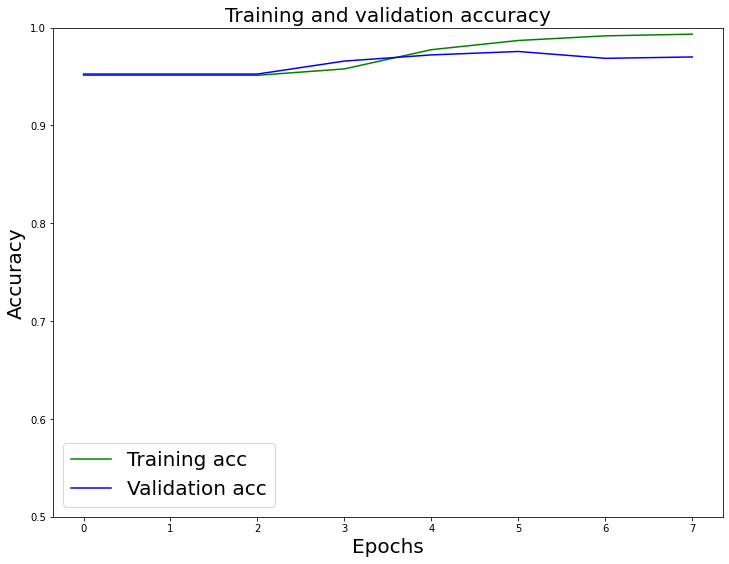

In [506]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [507]:
model.evaluate(X_test, y_test)

112/112 [==============================] - 9s 83ms/step - loss: 0.0944 - accuracy: 0.9765


[0.09441827982664108, 0.9765100479125977]

In [508]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [522]:
Accuracy["Rnn"]=accuracy_score(binary_predictions, y_test)*100
Mean_Squared_Error["Rnn"]=mean_squared_error(binary_predictions, y_test)
Roc_auc_score["Rnn"]=roc_auc_score(binary_predictions, y_test)

print("Accuracy of Recurrent Neural Network Classifier: {}%".format(round(accuracy_score(binary_predictions, y_test)*100,2)))
print("\nMean Squared Error:", mean_squared_error(binary_predictions, y_test))
print ("Roc_auc_score of Recurrent Neural Network Classifier: {}%".format(roc_auc_score(binary_predictions, y_test)))

print("\nConfusion Matrix of Recurrent Neural Network Classifier:\n")
print(confusion_matrix(binary_predictions, y_test))
print("\nClassification Report of Recurrent Neural Network Classifier:\n")
print(classification_report(binary_predictions, y_test))

Accuracy of Recurrent Neural Network Classifier: 97.65%

Mean Squared Error: 0.02348993288590604
Roc_auc_score of Recurrent Neural Network Classifier: 0.9113595583160802%

Confusion Matrix of Recurrent Neural Network Classifier:

[[3386   64]
 [  20  106]]

Classification Report of Recurrent Neural Network Classifier:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3450
           1       0.62      0.84      0.72       126

    accuracy                           0.98      3576
   macro avg       0.81      0.91      0.85      3576
weighted avg       0.98      0.98      0.98      3576



In [523]:
Accuracy

{'Decision_tree': 97.6323639075317,
 'Support_Vector': 98.52721849366145,
 'Logistic': 96.86800894854586,
 'AdaBoost': 96.97986577181209,
 'Random_Forest': 98.00521998508576,
 'K_Nearest_Neighbors': 98.13571961222968,
 'MLPAdam': 98.63907531692767,
 'MLPsgd': 98.47129008202835,
 'NaiveBayes': 98.28486204325131,
 'Rnn': 97.6510067114094}

In [524]:
Mean_Squared_Error

{'Decision_tree': 0.023676360924683074,
 'Support_Vector': 0.014727815063385533,
 'Logistic': 0.03131991051454139,
 'AdaBoost': 0.030201342281879196,
 'Random_Forest': 0.019947800149142433,
 'K_Nearest_Neighbors': 0.018642803877703208,
 'MLPAdam': 0.013609246830723341,
 'MLPsgd': 0.015287099179716629,
 'NaiveBayes': 0.01715137956748695,
 'Rnn': 0.02348993288590604}

In [525]:
Roc_auc_score

{'Decision_tree': 0.8578031068079673,
 'Support_Vector': 0.8625210152019128,
 'Logistic': 0.698457666920493,
 'AdaBoost': 0.7775585675669346,
 'Random_Forest': 0.8068592057761732,
 'K_Nearest_Neighbors': 0.8689907522466483,
 'MLPAdam': 0.9115576469010644,
 'MLPsgd': 0.8718764738106467,
 'NaiveBayes': 0.8205152392721373,
 'Rnn': 0.9113595583160802}

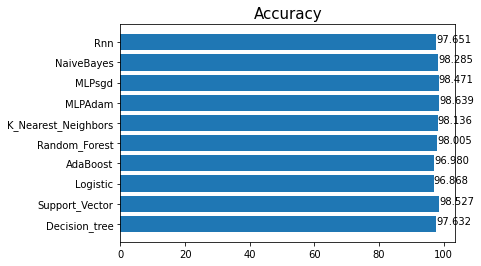

In [526]:
plt.barh(list(Accuracy.keys()),list(Accuracy.values()))
plt.title("Accuracy",fontsize=15)
for index, value in enumerate(Accuracy.values()):
    plt.text(value, index, format(value, ".3f"))

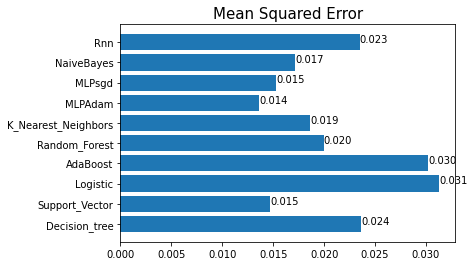

In [527]:
plt.barh(list(Mean_Squared_Error.keys()),Mean_Squared_Error.values())
plt.title("Mean Squared Error",fontsize=15)
for index, value in enumerate(Mean_Squared_Error.values()):
    plt.text(value, index, format(value, ".3f"))

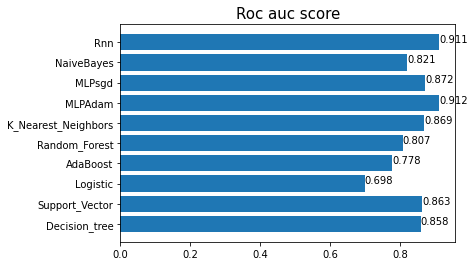

In [528]:
plt.barh(list(Roc_auc_score.keys()),Roc_auc_score.values())
plt.title("Roc auc score",fontsize=15)
for index, value in enumerate(Roc_auc_score.values()):
    plt.text(value, index, format(value, ".3f"))

In [ ]:
import pickle
file= open('MLP_sgd.pkl','wb')

pickle.dump(mlps,file)

In [517]:
import pickle
file= open('MLP_sgd.pkl','wb')

pickle.dump(mlps,file)

In [518]:
import pickle
file= open('Random_Forest.pkl','wb')

pickle.dump(model_Random_Forest,file)

In [ ]:
import pickle
file= open('AdaBoost.pkl','wb')

pickle.dump(AdaBoost_Classifier_pipe,file)